<a href="https://colab.research.google.com/github/djbrady/invisibleHeadlights/blob/master/DARPAInvisibleHeadlights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DARPA Invisible Headlights Program 

## Hyperspectral Measurement System Concept

## David Brady
## Duke University

## May 2020

## Background

This notebook considers various technical issues arising in the DARPA Invisible Headlights program. Duke, UC Davis and JPL jointly propose to build heterogenous sensor systems to detect range for invisible headlights. 

The project uses compressive spectral imaging. In contrast with CASSI-style spectral imagers, we implement multiscale optical design to make the spectral imager more compact and specific to the problem at hand. 

In phase I we will explore several spectral sensing strategies, including implementing intrisic spectral filtering in pixels, incorporating plasmonic or quantum dot filters as well as dispersive designs. we will use metalenses in secondary optics and may also use mems modulators. 

This note book explores the type of spectral features we seek to detect. 

### Initialization

In [0]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]


## System Concept

We propose 3d imaging sensors using differential infrared spectroscopy. This notebook considers


1.   Total power available per pixel as a function of range.
2.   Range Resolution as a function of attenuation constant. 

we assume a 10 cm collection aperture, but a ground sample distance of .1 cm. Resolving .1 cm at 300 meters requires an aperture satisfying
$${\lambda R\over F}<0.05$$
so for $\lambda=5\mu $ and $R=350$ m, we require $F>35 mm$, at this focal length active focus is a critical part of the sensor system. 


## Power per pixel

we asume that typical objects are black body radiators. Accordingly, the power radiated is tive by the stefan-boltzman relationship. For ground target area 10 cm, the radiated power per pixel is give below at 300K

In [0]:
# stefan-boltzman constant
sig= 5.67*10**(-8) # W/(m2K4
h=6.6*10**(-34);
c=3*10**8;
k=1.38064852*10**(-23) #m2 kg s-2 K-1;
def powerRad(gsd,T):
  p=sig*T**4.*gsd
  return p

In [0]:
powerRad(0.1**2,300)

4.592700000000001

In [0]:
# power per pixel as a function of range, gsd and aperture
def pp(T, gsd, R , aperture):
  pp=((aperture/(2*R))**2)*powerRad(gsd,T)
  return pp

In [0]:
pp(300,.1,350,.1)

9.372857142857144e-07

so we get about 1 microwatt per pixel integrated over all wavelengths. Let's now consider the power sepctral density. According to Plank's law, the power per unit solid angle per unit wavelength per unit source area is

$$S(\lambda, T) ={2hc^2\over \lambda^5}{1\over e^{hc\over\lambda k T}-1}$$


In [0]:
# power spectral density at the detector as a function of gsd, range, aperture
def B(lam,T, gsd, R , aperture):
  bb=((gsd *aperture/R)**2)*(2*h*(c**2)/(lam**5))*(1/(np.exp(h*c/(lam*k*T))-1));
  return bb

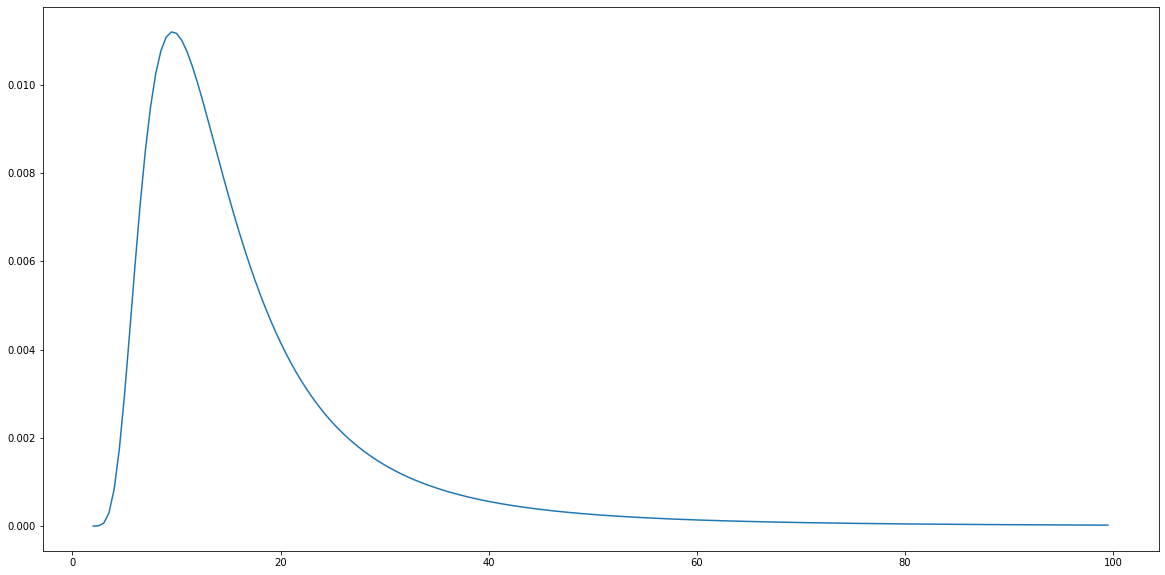

In [0]:
lamR=np.arange(2,100,.5);
plt.plot(lamR,B(10**(-6)*lamR,300,.1,300,.1))

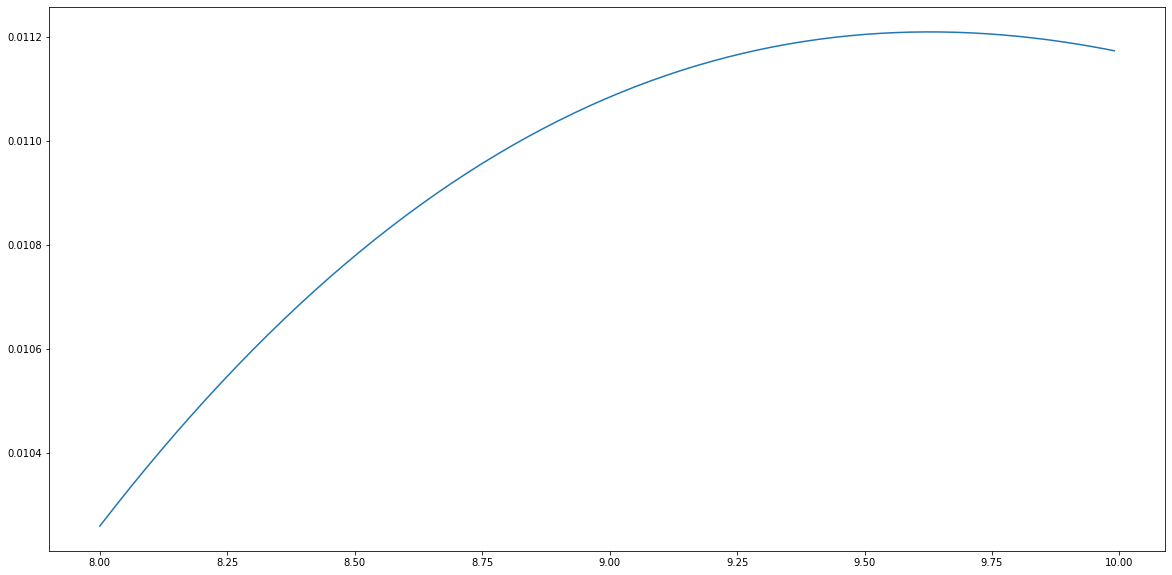

In [0]:
lamR=np.arange(8,10,.01);
plt.plot(lamR,B(10**(-6)*lamR,300,.1,300,.1))

If we measure a spectral line of width $\delta \lambda$, say  the energy in that spectral line is

In [0]:
dl=10.**-9 # 1 nm
lam = 8.*10.**-6 # 8 micorns
energy=dl*B(lam,300,.1,300,.1)
print('energy = %e'%energy)

energy = 1.025941e-11


## infrared absorption spectra
spectral down loaded from 
https://www.gemini.edu/observing/telescopes-and-sites/sites#Transmission


In [0]:
!wget http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/mktrans_zm_50_10.dat
!wget http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/mktrans_nq_50_10.dat
!ls

--2020-05-04 13:45:23--  http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/mktrans_zm_50_10.dat
Resolving www.gemini.edu (www.gemini.edu)... 128.171.188.185
Connecting to www.gemini.edu (www.gemini.edu)|128.171.188.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196485 (5.0M) [application/x-troff]
Saving to: ‘mktrans_zm_50_10.dat’

mktrans_zm_50_10.da 100%[===================>]   4.96M  6.28MB/s    in 0.8s    

2020-05-04 13:45:24 (6.28 MB/s) - ‘mktrans_zm_50_10.dat’ saved [5196485/5196485]

--2020-05-04 13:45:25--  http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/mktrans_nq_50_10.dat
Resolving www.gemini.edu (www.gemini.edu)... 128.171.188.185
Connecting to www.gemini.edu (www.gemini.edu)|128.171.188.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4134842 (3.9M)
Saving to: ‘mktrans_nq_50_10.dat’

mktrans_nq_50_10.da 100%[===================>]   3.94M  5.53MB/s    in 0.7s    

2020-05-04 13:45:2

In [0]:
midwaveSpectrum = pd.read_table('./mktrans_zm_50_10.dat', sep='\s+', names=['wavelength','attenuation'])
print(midwaveSpectrum)

        wavelength  attenuation
0          0.90000     0.997119
1          0.90002     0.997048
2          0.90004     0.997117
3          0.90006     0.996095
4          0.90008     0.994900
...            ...          ...
234995     5.59990     0.015020
234996     5.59992     0.014688
234997     5.59994     0.014295
234998     5.59996     0.013891
234999     5.59998     0.013446

[235000 rows x 2 columns]


In [0]:
longwaveSpectrum = pd.read_table('./mktrans_nq_50_10.dat', sep='\s+', names=['wavelength','attenuation'])
print(longwaveSpectrum)

        wavelength   attenuation
0           7.0000  6.347910e-04
1           7.0001  5.403920e-04
2           7.0002  4.166090e-04
3           7.0003  2.899340e-04
4           7.0004  1.781150e-04
...            ...           ...
189996     25.9996  0.000000e+00
189997     25.9997  0.000000e+00
189998     25.9998  0.000000e+00
189999     25.9999  0.000000e+00
190000     26.0000  1.000000e-18

[190001 rows x 2 columns]


typical values of infrared extinction coefficients:

Extinction coefficient, b

3-5 microns
6.7 x 10-5 m-1

8-12 microns
2.0 x 10-4 m-1




(0.0, 1.0)

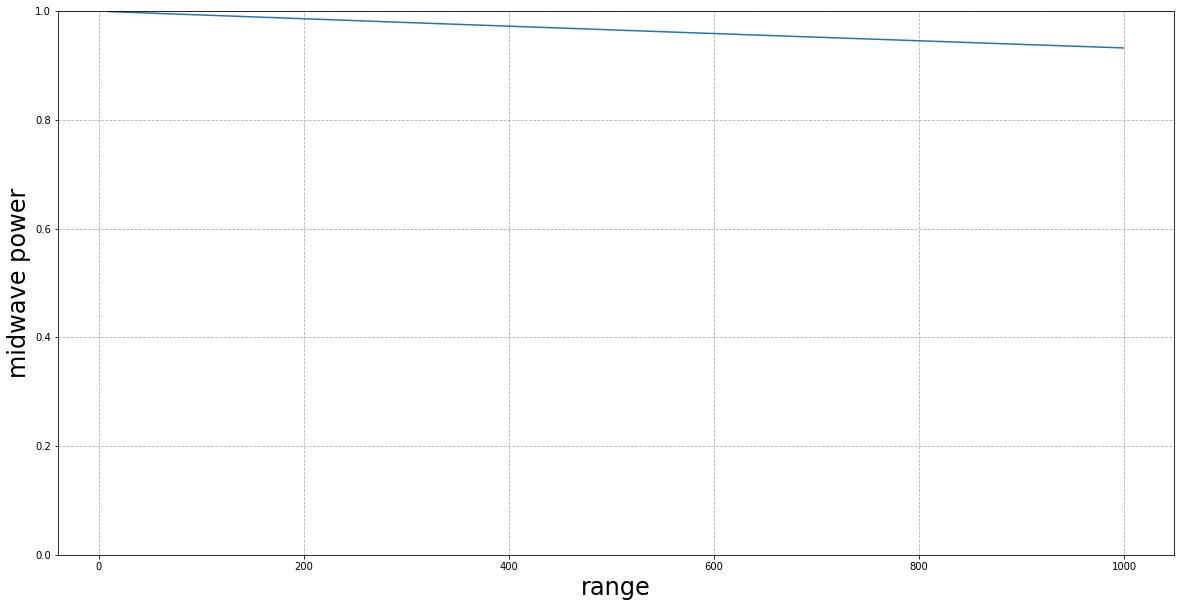

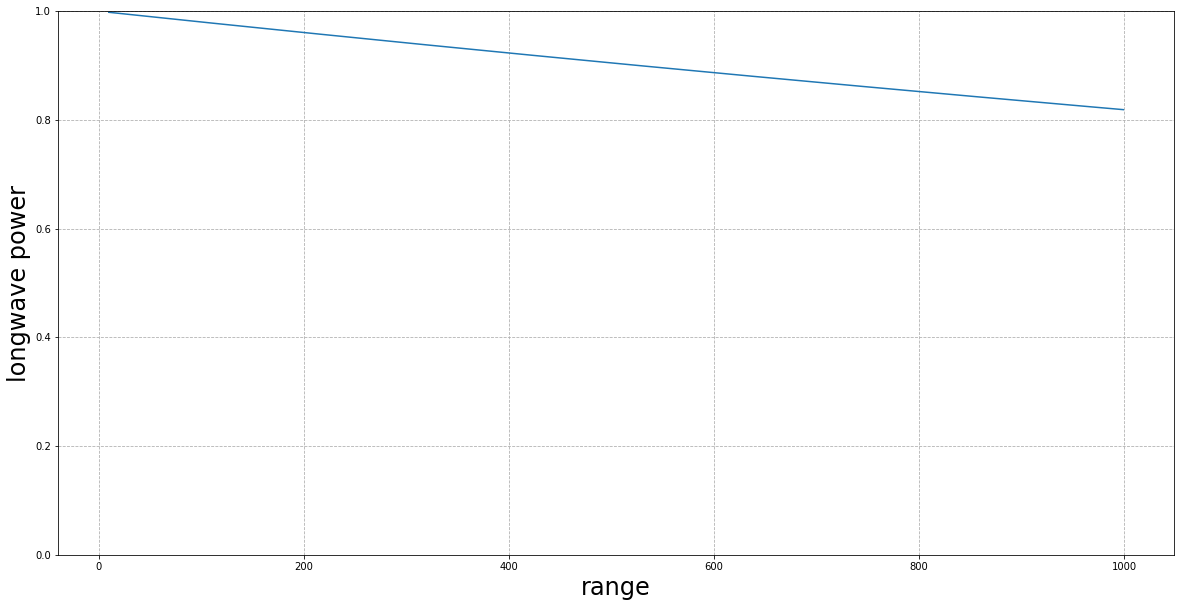

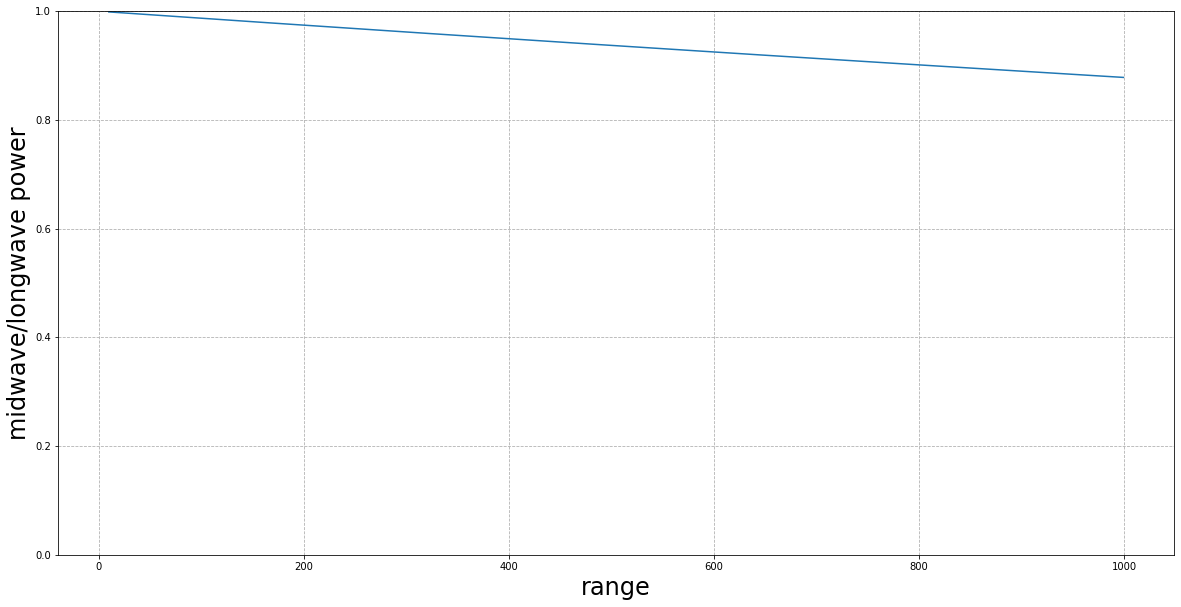

In [0]:
# relative extinction of lw and midw wave vs range
mwb=7.*10.**(-5);
lwb=2.*10**(-4);
zrange=np.arange(10,1000,1)
fig = plt.figure()
plt.plot(zrange,np.exp(-mwb*zrange))
plt.xlabel('range',fontsize=24)
plt.ylabel('midwave power',fontsize=24)
plt.grid(linestyle='--')
plt.ylim(0, 1)
fig = plt.figure()
plt.plot(zrange,np.exp(-lwb*zrange))
plt.xlabel('range',fontsize=24)
plt.ylabel('longwave power',fontsize=24)
plt.grid(linestyle='--')
plt.ylim(0, 1)
fig = plt.figure()
plt.plot(zrange,np.exp(-(lwb-mwb)*zrange))
plt.xlabel('range',fontsize=24)
plt.ylabel('midwave/longwave power',fontsize=24)
plt.grid(linestyle='--')
plt.ylim(0, 1)


range estimation from a single wavelength requires substantial dynamic range. Next we consider the dependance on the hyperspectral transmission spectrum on range. 

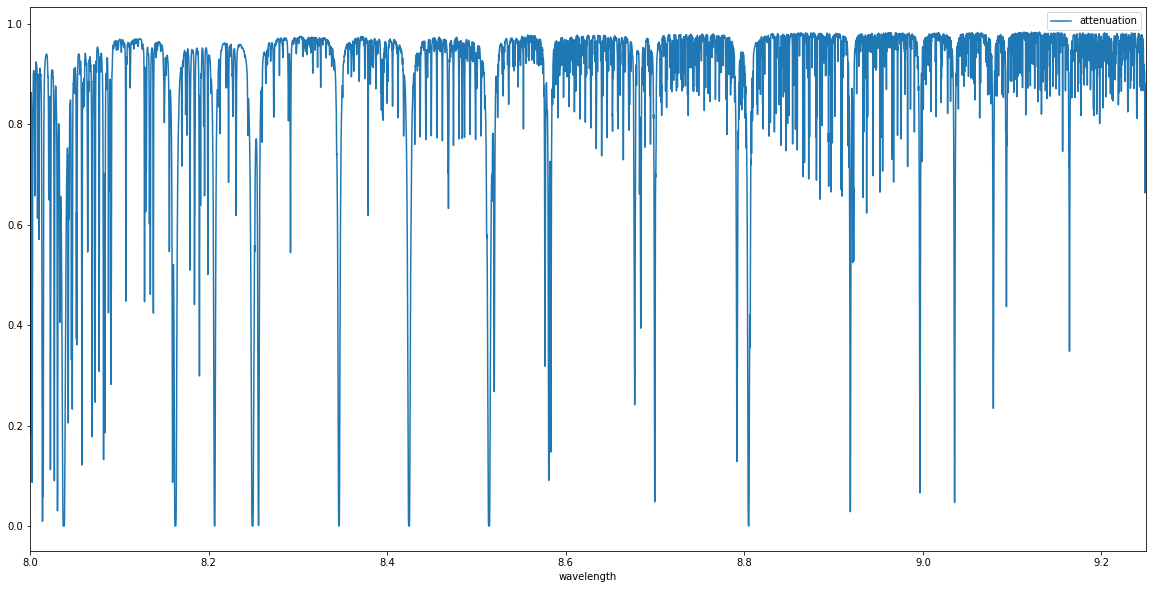

In [0]:
ax = plt.gca()

longwaveSpectrum.plot(kind='line',x='wavelength',y='attenuation',xlim=(8,9.25),ax=ax)

plt.show()

In [0]:
longwaveSpectrum['coefficient']= 0.5*(10.**(-4))*np.log(longwaveSpectrum['attenuation']+10**(-9))


In [0]:
longwaveSpectrum.mean()

wavelength     16.500000
attenuation     0.445407
coefficient    -0.000245
dtype: float64

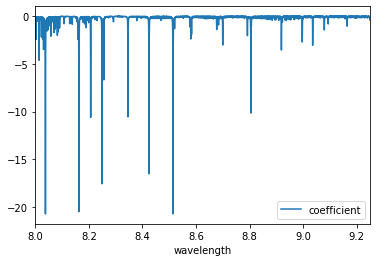

In [0]:
ax = plt.gca()

longwaveSpectrum.plot(kind='line',x='wavelength',y='coefficient',xlim=(8,9.25),ax=ax)

plt.show()

In [0]:
longwaveSpectrum['100meters']=np.exp(longwaveSpectrum['coefficient']*100)
longwaveSpectrum['300meters']=np.exp(longwaveSpectrum['coefficient']*300)
longwaveSpectrum['1000meters']=np.exp(longwaveSpectrum['coefficient']*1000)

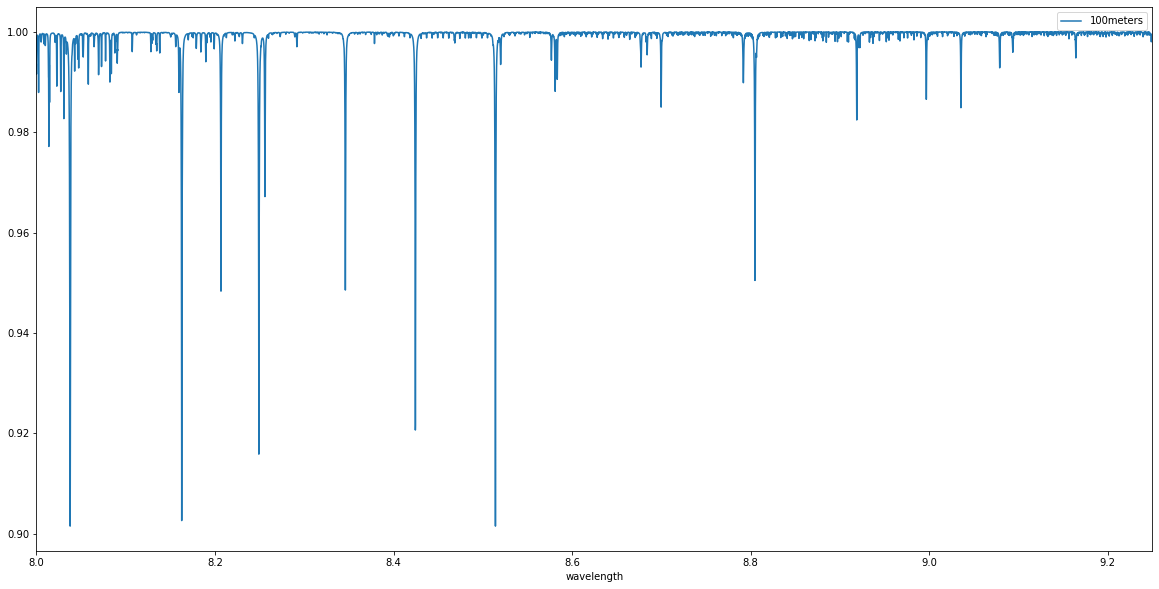

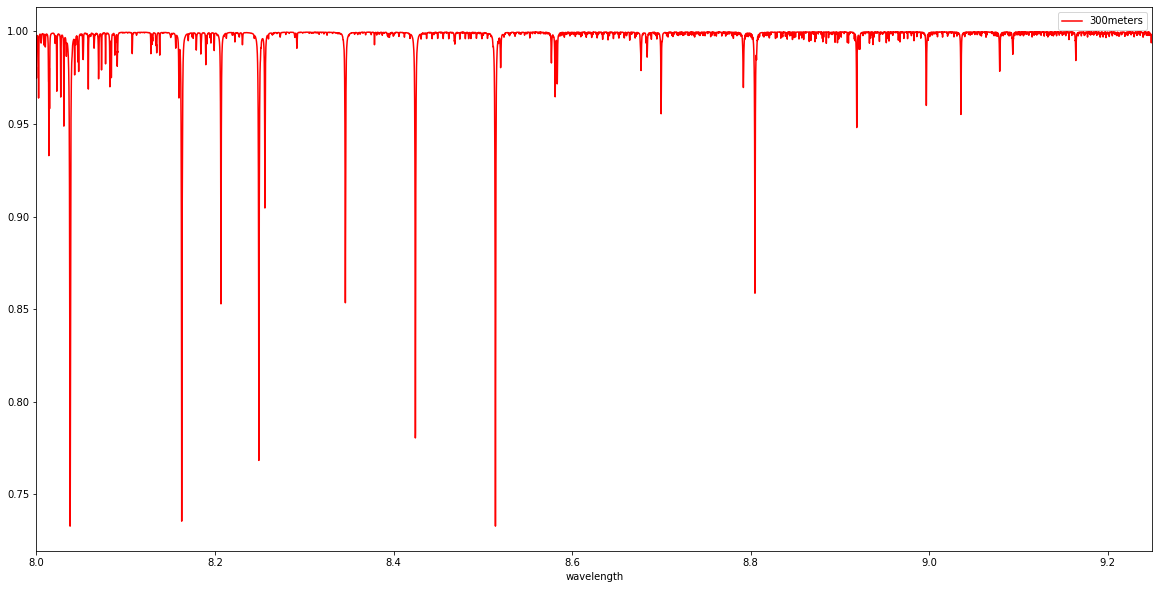

In [0]:
ax = plt.gca()

longwaveSpectrum.plot(kind='line',x='wavelength',y='100meters',xlim=(8,9.25),ax=ax)
#longwaveSpectrum.plot(kind='line',x='wavelength',y='300meters',color='red',xlim=(8,9.25),ax=ax)
#longwaveSpectrum.plot(kind='line',x='wavelength',y='1000meters',color='green',xlim=(8,9.25),ax=ax)

plt.show()
plt.figure
ax=plt.gca()

#longwaveSpectrum.plot(kind='line',x='wavelength',y='100meters',xlim=(8,9.25),ax=ax)
longwaveSpectrum.plot(kind='line',x='wavelength',y='300meters',color='red',xlim=(8,9.25),ax=ax)
#longwaveSpectrum.plot(kind='line',x='wavelength',y='1000meters',color='green',xlim=(8,9.25),ax=ax)

plt.show()

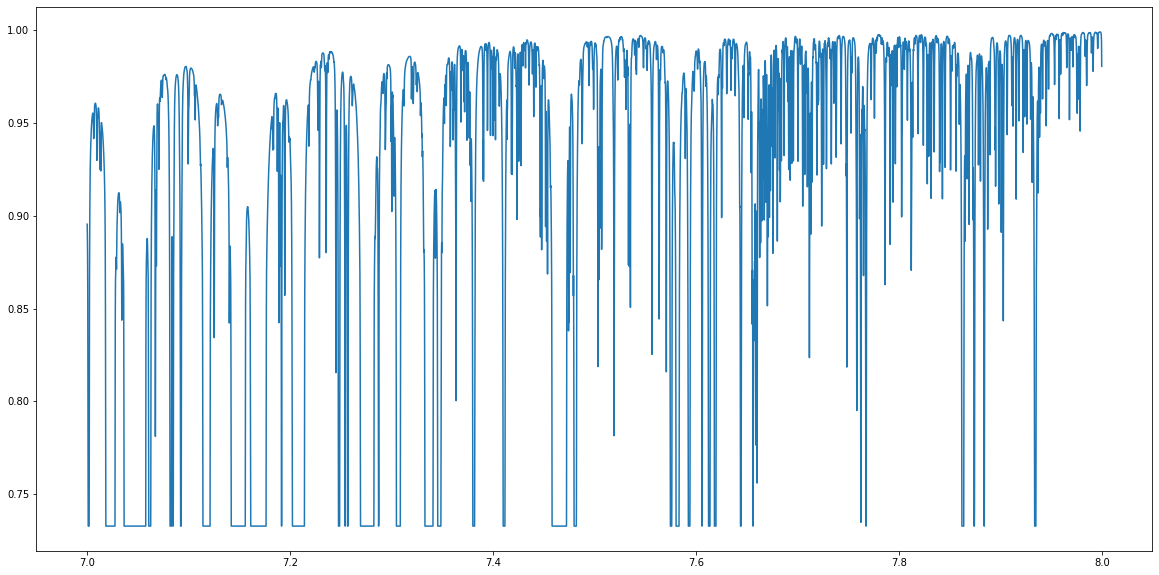

In [0]:
plt.plot(longwaveSpectrum['wavelength'][0:10000],longwaveSpectrum['300meters'][0:10000])

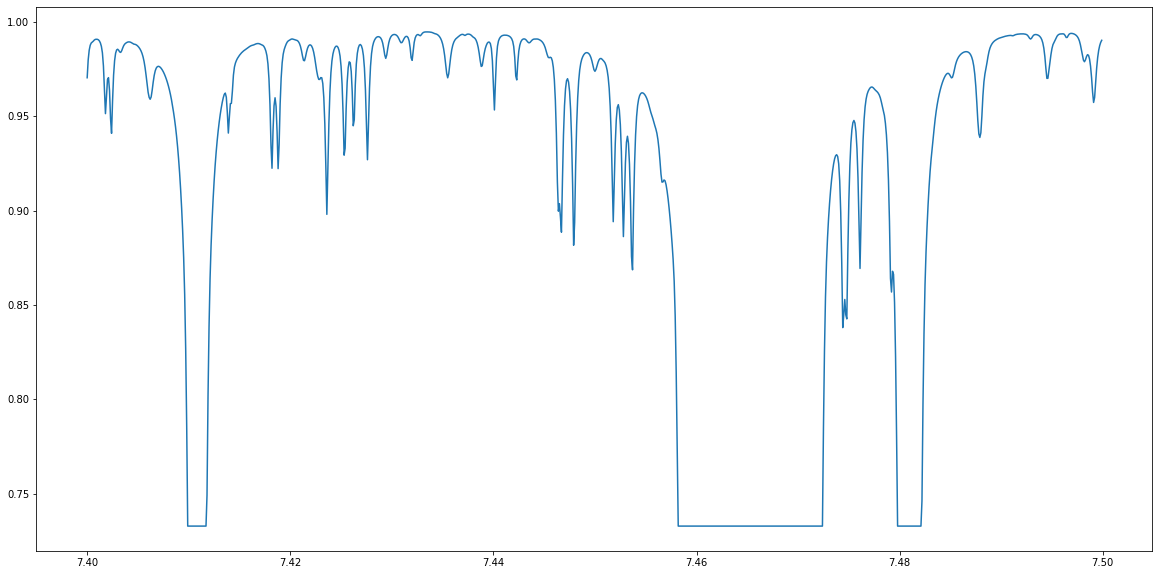

In [0]:
plt.plot(longwaveSpectrum['wavelength'][4000:5000],longwaveSpectrum['300meters'][4000:5000])

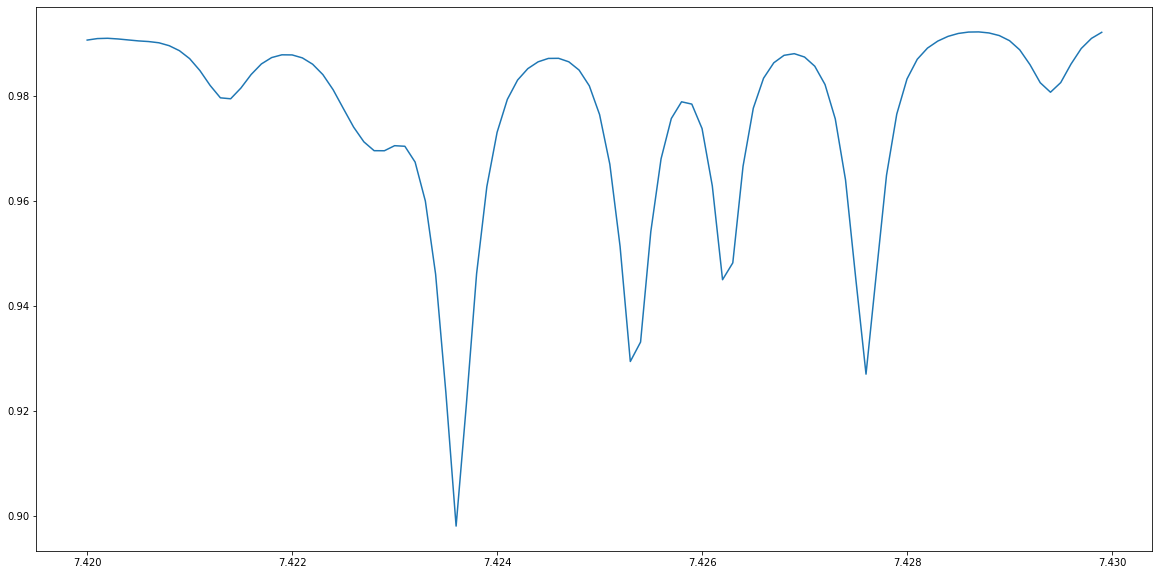

In [0]:
plt.plot(longwaveSpectrum['wavelength'][4200:4300],longwaveSpectrum['300meters'][4200:4300])

In [0]:
absorptionImage=np.zeros((1000,10000),dtype=float)
for ct in range(1000):
  pip=10.+ct*490./1000.
  absorptionImage[ct,:]=np.exp(longwaveSpectrum['coefficient'][0:10000]*pip)

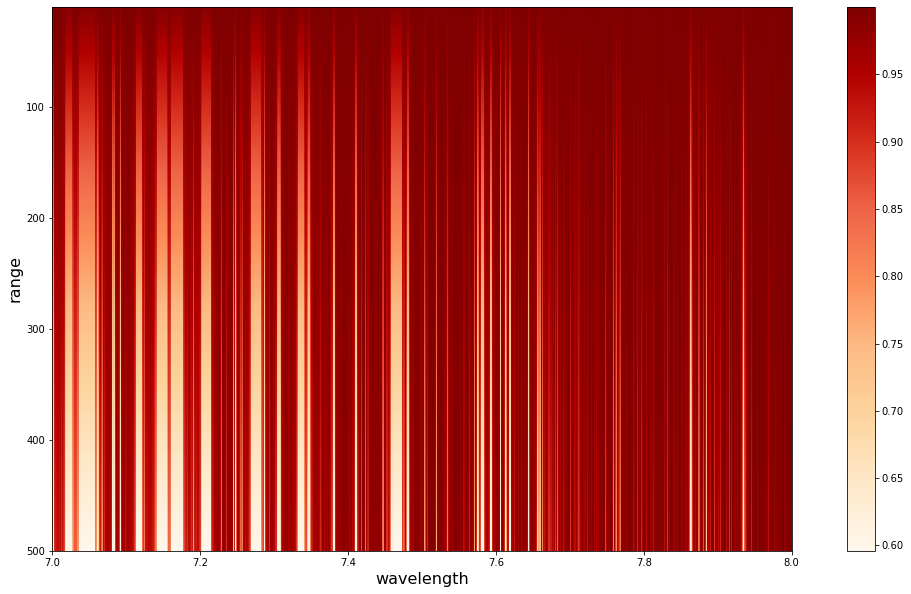

In [0]:
plt.imshow(absorptionImage,cmap='OrRd',interpolation='none',aspect=.0015,extent=[7,8,500,10])
plt.xlabel('wavelength',fontsize=16)
plt.ylabel('range',fontsize=16)
plt.colorbar()



In [0]:
absorptionImage=np.zeros((1000,1000),dtype=float)
for ct in range(1000):
  pip=10.+ct*490./1000.
  absorptionImage[ct,:]=np.exp(longwaveSpectrum['coefficient'][4000:5000]*pip)

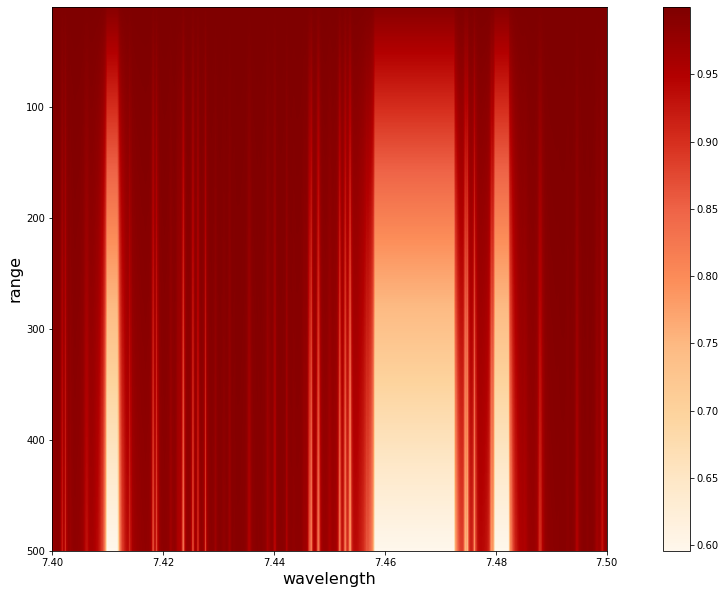

In [0]:
plt.imshow(absorptionImage,cmap='OrRd',interpolation='none',aspect=.0002,extent=[7.4,7.5,500,10])
plt.xlabel('wavelength',fontsize=16)
plt.ylabel('range',fontsize=16)
plt.colorbar()